In [1]:
import json
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import emoji

In [2]:
data = []
with open('tweet/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line)) 
f.close()

emotion = pd.read_csv('tweet/emotion.csv')
data_identification = pd.read_csv('tweet/data_identification.csv')

df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

train_data = train_data.merge(emotion, on='tweet_id', how='left')
train_data

tweet_id                       hashtags  \
0        0x376b20                     [Snapchat]   
1        0x2d5350  [freepress, TrumpLegacy, CNN]   
2        0x1cd5b0                             []   
3        0x1d755c      [authentic, LaughOutLoud]   
4        0x2c91a8                             []   
...           ...                            ...   
1455558  0x321566              [NoWonder, Happy]   
1455559  0x38959e                             []   
1455560  0x2cbca6                     [blessyou]   
1455561  0x24faed                             []   
1455562  0x34be8c                  [Sundayvibes]   

                                                      text identification  \
0        People who post "add me on #Snapchat" must be ...          train   
1        @brianklaas As we see, Trump is dangerous to #...          train   
2                      Now ISSA is stalking Tasha 😂😂😂 <LH>          train   
3        @RISKshow @TheKevinAllison Thx for the BEST TI...          train   
4             Still waiting on those supplies Liscus. <LH>          train   
...                                                    ...            ...   
1455558  I'm SO HAPPY!!! #NoWonder the name of this sho...          train   
1455559  In every circumtance I'd like to be thankful t...          train   
1455560  there's currently two girls walking around the...          train   
1455561  Ah, corporate life, where you can date <LH> us...          train   
1455562             Blessed to be living #Sundayvibes <LH>          train   

              emotion  
0        anticipation  
1             sadness  
2                fear  
3                 joy  
4        anticipation  
...               ...  
1455558           joy  
1455559           joy  
1455560           joy  
1455561           joy  
1455562           joy  

[1455563 rows x 5 columns]

In [3]:
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)
train_data

tweet_id                       hashtags  \
0        0x376b20                     [Snapchat]   
1        0x2d5350  [freepress, TrumpLegacy, CNN]   
2        0x1cd5b0                             []   
3        0x1d755c      [authentic, LaughOutLoud]   
4        0x2c91a8                             []   
...           ...                            ...   
1455558  0x321566              [NoWonder, Happy]   
1455559  0x38959e                             []   
1455560  0x2cbca6                     [blessyou]   
1455561  0x24faed                             []   
1455562  0x34be8c                  [Sundayvibes]   

                                                      text identification  \
0        People who post "add me on #Snapchat" must be ...          train   
1        @brianklaas As we see, Trump is dangerous to #...          train   
2                      Now ISSA is stalking Tasha 😂😂😂 <LH>          train   
3        @RISKshow @TheKevinAllison Thx for the BEST TI...          train   
4             Still waiting on those supplies Liscus. <LH>          train   
...                                                    ...            ...   
1455558  I'm SO HAPPY!!! #NoWonder the name of this sho...          train   
1455559  In every circumtance I'd like to be thankful t...          train   
1455560  there's currently two girls walking around the...          train   
1455561  Ah, corporate life, where you can date <LH> us...          train   
1455562             Blessed to be living #Sundayvibes <LH>          train   

              emotion  
0        anticipation  
1             sadness  
2                fear  
3                 joy  
4        anticipation  
...               ...  
1455558           joy  
1455559           joy  
1455560           joy  
1455561           joy  
1455562           joy  

[1449182 rows x 5 columns]

In [4]:
train_data_sample = train_data.sample(frac=0.3, random_state=42)
train_data_sample.to_pickle("train_dsample.pkl")
train_df = pd.read_pickle("train_dsample.pkl")

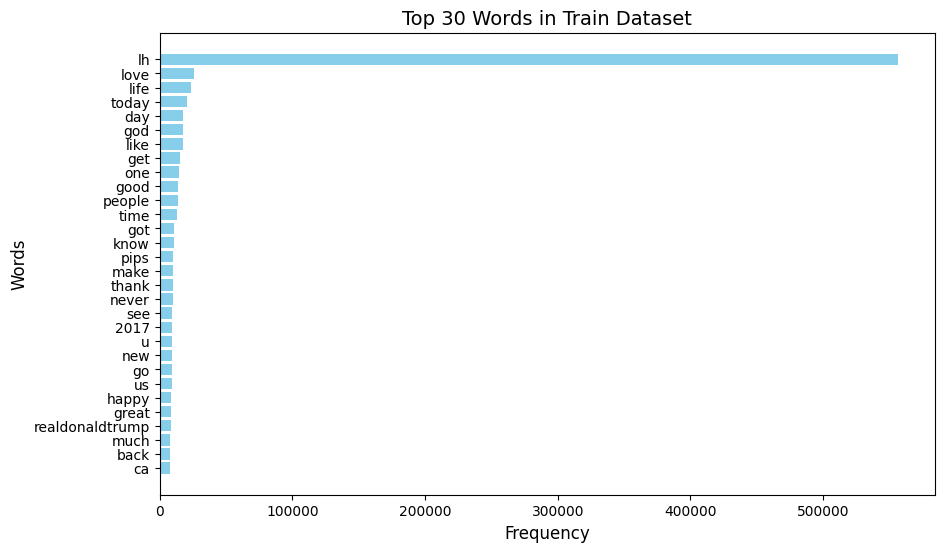

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

def tokenize_and_count(text_list):
    stop_words = set(stopwords.words('english'))
    words = []
    for text in text_list:
        tokens = word_tokenize(text.lower())
        words.extend([word for word in tokens if word.isalnum() and word not in stop_words])
    return Counter(words)

# Get word frequencies for train
train_word_counts = tokenize_and_count(train_data_sample['text'])

# Extract the top 30 words for each dataset
top_train_words = train_word_counts.most_common(30)

# Plot the word frequencies
def plot_word_frequencies(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.show()

# Plot for train dataset
plot_word_frequencies(top_train_words, "Top 30 Words in Train Dataset")

emotion
joy             154445
anticipation     74110
trust            61615
sadness          57586
disgust          41614
fear             19076
surprise         14240
anger            12069
Name: count, dtype: int64


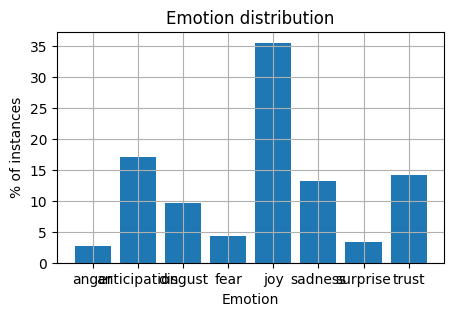

In [6]:
train_df.groupby(['emotion']).count()['text']
print(train_df['emotion'].value_counts())

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

In [8]:
from sklearn.utils import resample

# 分群處理
minority_classes = train_df['emotion'].value_counts().min()
balanced_df = pd.concat([
    resample(train_df[train_df['emotion'] == emotion], 
             replace=False, # 不重複抽樣
             n_samples=minority_classes, 
             random_state=42)
    for emotion in train_df['emotion'].unique()
])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['emotion'].value_counts())

emotion
disgust         12069
anticipation    12069
sadness         12069
fear            12069
anger           12069
joy             12069
trust           12069
surprise        12069
Name: count, dtype: int64


In [9]:
emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

def preprocess_text(text):
    # 將定義的表情符號替換為對應的關鍵詞
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    # 移除其餘的表情符號
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'http\S+', '', text)
    text = text.replace('<LH>', '')
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'@\w+', '', text)
    text = ' '.join(text.split())
    text = text.lower()  
    text = text.strip()
    return text

balanced_df['processed_text'] = balanced_df['text'].apply(preprocess_text)
balanced_df

tweet_id                            hashtags  \
0      0x32cbfb        [WeChoose, WheresTheFunding]   
1      0x35fcdc                             [shame]   
2      0x23c1d0                              [Life]   
3      0x24bcbb                             [Exams]   
4      0x2fb40d                                  []   
...         ...                                 ...   
96547  0x24436b                                  []   
96548  0x2cbf58                                  []   
96549  0x38687a                                  []   
96550  0x2c72d1                 [dick, gaythoughts]   
96551  0x1eae6b  [bully, DontKillUs, THERESISTANCE]   

                                                    text identification  \
0      #WeChoose Teachers say they want cultural comp...          train   
1      @ProudResister @jacksnowknows the fact that he...          train   
2      73 The moments in your life are only once #Lif...          train   
3                          Exam sucks...!!! #Exams  <LH>          train   
4      there’s no way in hell im playing the evil wit...          train   
...                                                  ...            ...   
96547  @CCharities_GHTX You are welcome! Have a <LH> ...          train   
96548  @Michell76657729 Thank you VERY much for the f...          train   
96549  @Foxnews you should be fucking <LH> of your se...          train   
96550  Real men care about the size of your heart. No...          train   
96551  .@SenBobCorker  U caved to a #bully U must fee...          train   

            emotion                                     processed_text  
0           disgust  wechoose teachers say they want cultural compe...  
1           disgust  proudresister jacksnowknows the fact that he d...  
2      anticipation  73 the moments in your life are only once life...  
3           sadness                                   exam sucks exams  
4              fear  theres no way in hell im playing the evil with...  
...             ...                                                ...  
96547           joy         ccharitiesghtx you are welcome have a week  
96548  anticipation  michell76657729 thank you very much for the fo...  
96549       sadness  foxnews you should be fucking of your self eve...  
96550           joy  real men care about the size of your heart not...  
96551       disgust  senbobcorker u caved to a bully u must feel to...  

[96552 rows x 6 columns]

In [10]:
# 创建标签编码器
label_encoder = LabelEncoder()
balanced_df['emotion_encoded'] = label_encoder.fit_transform(balanced_df['emotion'])

# 获取类别映射
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
inverse_label_map = {v: k for k, v in label_map.items()}

balanced_df

tweet_id                            hashtags  \
0      0x32cbfb        [WeChoose, WheresTheFunding]   
1      0x35fcdc                             [shame]   
2      0x23c1d0                              [Life]   
3      0x24bcbb                             [Exams]   
4      0x2fb40d                                  []   
...         ...                                 ...   
96547  0x24436b                                  []   
96548  0x2cbf58                                  []   
96549  0x38687a                                  []   
96550  0x2c72d1                 [dick, gaythoughts]   
96551  0x1eae6b  [bully, DontKillUs, THERESISTANCE]   

                                                    text identification  \
0      #WeChoose Teachers say they want cultural comp...          train   
1      @ProudResister @jacksnowknows the fact that he...          train   
2      73 The moments in your life are only once #Lif...          train   
3                          Exam sucks...!!! #Exams  <LH>          train   
4      there’s no way in hell im playing the evil wit...          train   
...                                                  ...            ...   
96547  @CCharities_GHTX You are welcome! Have a <LH> ...          train   
96548  @Michell76657729 Thank you VERY much for the f...          train   
96549  @Foxnews you should be fucking <LH> of your se...          train   
96550  Real men care about the size of your heart. No...          train   
96551  .@SenBobCorker  U caved to a #bully U must fee...          train   

            emotion                                     processed_text  \
0           disgust  wechoose teachers say they want cultural compe...   
1           disgust  proudresister jacksnowknows the fact that he d...   
2      anticipation  73 the moments in your life are only once life...   
3           sadness                                   exam sucks exams   
4              fear  theres no way in hell im playing the evil with...   
...             ...                                                ...   
96547           joy         ccharitiesghtx you are welcome have a week   
96548  anticipation  michell76657729 thank you very much for the fo...   
96549       sadness  foxnews you should be fucking of your self eve...   
96550           joy  real men care about the size of your heart not...   
96551       disgust  senbobcorker u caved to a bully u must feel to...   

       emotion_encoded  
0                    2  
1                    2  
2                    1  
3                    5  
4                    3  
...                ...  
96547                4  
96548                1  
96549                5  
96550                4  
96551                2  

[96552 rows x 7 columns]

In [11]:
# Word2Vec 訓練與文本向量化
from gensim.models import Word2Vec

def train_word2vec(texts, vector_size=100, window=5, min_count=1):
    tokenized_texts = [text.split() for text in texts]
    return Word2Vec(sentences=tokenized_texts, vector_size=vector_size, window=window, min_count=min_count, workers=4)

word2vec_model = train_word2vec(balanced_df['processed_text'])

def text_to_vector(text, word2vec_model, max_length=50):
    words = text.split()
    vector = np.zeros((max_length, word2vec_model.vector_size))
    for i, word in enumerate(words[:max_length]):
        if word in word2vec_model.wv.key_to_index:
            vector[i] = word2vec_model.wv[word]
    return vector

w2v_features = np.stack(balanced_df['processed_text'].apply(lambda x: text_to_vector(x, word2vec_model)))

In [12]:
# 處理 hashtags
def process_hashtags(hashtags):
    if isinstance(hashtags, list):
        return ' '.join(hashtags)
    try:
        hashtags = eval(hashtags)
        return ' '.join(hashtags)
    except:
        return '[no_hashtag]'

balanced_df['hashtag_text'] = balanced_df['hashtags'].apply(process_hashtags)
tfidf_vectorizer = TfidfVectorizer(max_features=100)
hashtag_tfidf = tfidf_vectorizer.fit_transform(balanced_df['hashtag_text']).toarray()

# balanced_df['hashtag_count'] = balanced_df['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) and x != 'nan' else 0)
# hashtag_features = np.hstack((hashtag_tfidf, balanced_df[['hashtag_count']].values))

# 合併所有特徵
combined_features = np.hstack((w2v_features.reshape(w2v_features.shape[0], -1), hashtag_tfidf))

In [13]:
# 數據集類
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.tensor(self.labels[idx])
# # 創建數據集類
# class EmotionDataset(Dataset):
#     def __init__(self, features, labels):
#         self.features = features  # 直接存取 NumPy 陣列
#         self.labels = labels      # NumPy 陣列中的標籤
#         self.label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
#         self.inverse_label_map = {idx: label for label, idx in self.label_map.items()}
    
#     def __len__(self):
#         return len(self.features)
    
#     def __getitem__(self, idx):
#         # 確保返回的是 Tensor
#         return torch.FloatTensor(self.features[idx]), self.label_map[self.labels[idx]]

In [14]:
# 模型定義
class TextClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TextClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)
# # CNN 模型
# class TextClassifier(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(TextClassifier, self).__init__()
#         self.fc = nn.Linear(input_size, num_classes)

#     def forward(self, x):
#         return self.fc(x)

In [15]:
# 訓練和評估函數
def train_model(train_features, val_features, train_labels, val_labels, num_classes, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     # 确保标签是numpy数组
    train_labels = np.array(train_labels)
    val_labels = np.array(val_labels)
    train_dataset = EmotionDataset(train_features, train_labels)
    val_dataset = EmotionDataset(val_features, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    
    textmodel = TextClassifier(input_size=combined_features.shape[1], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(textmodel.parameters(), lr=0.001)
    
    for epoch in range(epochs):
         textmodel.train()
         train_loss = 0
         for texts, labels in train_loader:
             texts, labels = texts.to(device), labels.to(device)
             optimizer.zero_grad()
             outputs = textmodel(texts)
             loss = criterion(outputs, labels)
             loss.backward()
             optimizer.step()
             train_loss += loss.item()
        
         textmodel.eval()
         val_loss = 0
         correct = 0
         total = 0
         with torch.no_grad():
             for texts, labels in val_loader:
                 texts, labels = texts.to(device), labels.to(device)
                 outputs = model(texts)
                 loss = criterion(outputs, labels)
                 val_loss += loss.item()
                 _, predicted = torch.max(outputs.data, 1)
                 total += labels.size(0)
                 correct += (predicted == labels).sum().item()
        
         print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {100*correct/total:.2f}%")

    return texttmodel
# # 模型訓練
# def train_model(train_dataset, val_dataset, input_size, num_classes, epochs=10):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=64)
#     model = TextClassifier(input_size=input_size, num_classes=num_classes).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0
#         for texts, labels in train_loader:
#             texts, labels = texts.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(texts)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
        
#         model.eval()
#         val_loss = 0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for texts, labels in val_loader:
#                 texts, labels = texts.to(device), labels.to(device)
#                 outputs = model(texts)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
        
#         print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {100*correct/total:.2f}%")
    
#     return model


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 混淆矩陣與分類報告
def evaluate_model(model, val_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 反向映射標籤
    inverse_label_map = {idx: label for label, idx in label_encoder.items()}
    all_preds_labels = [inverse_label_map[pred] for pred in all_preds]
    all_true_labels = [inverse_label_map[label] for label in all_labels]
    
    # 混淆矩陣
    cm = confusion_matrix(all_true_labels, all_preds_labels, labels=list(label_encoder.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # 分類報告
    report = classification_report(all_true_labels, all_preds_labels)
    print("Classification Report:")
    print(report)
    
    return cm, report
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.eval()
    # all_labels = []
    # all_predictions = []
    
    # with torch.no_grad():
    #     for batch in val_loader:
    #         features, labels = batch
    #         features = {k: v.to(device) for k, v in features.items()}
    #         labels = labels.to(device)
            
    #         outputs = model(features)
    #         _, predicted = torch.max(outputs.data, 1)
    #         all_labels.extend(labels.cpu().numpy())
    #         all_predictions.extend(predicted.cpu().numpy())
    
    # # 反向映射為原始情緒類別
    # label_map = dataset.label_map
    # inverse_label_map = {v: k for k, v in label_map.items()}
    # all_labels = [inverse_label_map[label] for label in all_labels]
    # all_predictions = [inverse_label_map[pred] for pred in all_predictions]
    
    # # 混淆矩陣
    # cm = confusion_matrix(all_labels, all_predictions, labels=sorted(set(all_labels)))
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt="d", xticklabels=sorted(set(all_labels)), yticklabels=sorted(set(all_labels)))
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()
    
    # # 分類報告
    # print(classification_report(all_labels, all_predictions))


In [16]:
# 數據分割
train_features, val_features, train_labels, val_labels = train_test_split(
    combined_features, 
    balanced_df['emotion_encoded'], 
    test_size=0.2, 
    random_state=42
)
# train_dataset = EmotionDataset(train_texts, train_labels)
# val_dataset = EmotionDataset(val_texts, val_labels)

# # 訓練模型
# input_size = combined_features.shape[1]
# num_classes = len(set(balanced_df['emotion']))
# trained_model = train_model(train_dataset, val_dataset, input_size, num_classes)

# val_loader = DataLoader(val_dataset, batch_size=64)
# evaluate_model(trained_model, val_loader, val_dataset)


In [21]:
val_labels

12212    1
18588    4
58721    5
84357    6
61904    3
        ..
28383    7
10081    7
94618    5
50968    6
90996    6
Name: emotion_encoded, Length: 19311, dtype: int32

In [15]:
# 打印label_encoder
print("Label Encoder:", label_encoder)

# 打印原始标签
print("Original Labels:", balanced_df['emotion'].unique())

# 打印编码后的标签
print("Encoded Labels:", balanced_df['emotion_encoded'].unique())

# 检查训练标签
print("Train Labels:", train_labels)
print("Train Labels Unique:", np.unique(train_labels))
balanced_df

Label Encoder: LabelEncoder()
Original Labels: ['joy' 'disgust' 'trust' 'surprise' 'anticipation' 'fear' 'sadness'
 'anger']
Encoded Labels: [4 2 7 6 1 3 5 0]
Train Labels: 773697     7
1332880    7
1287600    7
1277534    1
523199     1
          ..
257279     4
111177     1
1033936    5
384403     4
863615     2
Name: emotion_encoded, Length: 77241, dtype: int32
Train Labels Unique: [0 1 2 3 4 5 6 7]


tweet_id                                           hashtags  \
683086   0x2d5ff6                                                 []   
373916   0x33eca9                                                 []   
70944    0x334cb9                                          [SPECIAL]   
466445   0x376a2a  [bbcqt, likeback, followpyramid, ipad, followher]   
958921   0x1f4b10                                                 []   
...           ...                                                ...   
1244467  0x2ee74f                                                 []   
490273   0x3190ba                                                 []   
741800   0x1dce3d                                                 []   
705506   0x2c773b                                  [MadAsHell, late]   
1005130  0x1cf9f7                                  [SuperRugbyFinal]   

                                                      text identification  \
683086   Today we had buddy reading and did a Christmas...          train   
373916   So many things to look forward to the last of ...          train   
70944    @angelganev6 @gangwolf360 Congrats, and it is ...          train   
466445   sexy-blog #bbcqt <LH> #likeback #followpyramid...          train   
958921   @Kiesza You are absolutely  <LH>  I love your ...          train   
...                                                    ...            ...   
1244467  I never ever ever want to write an exegesis pa...          train   
490273   Are you kidding me @flyspicejet. SG-925 delaye...          train   
741800   @ThomsonCares I've spoken to the reps numerous...          train   
705506   My 1st @Uber @uberpool was horrible he drove r...          train   
1005130  Amateur hour mistakes by saders ABs - finals n...          train   

        emotion                                     processed_text  \
683086      joy  today we had buddy reading and did a christmas...   
373916      joy  so many things to look forward to the last of ...   
70944       joy  angelganev6 gangwolf360 congrats and it is spe...   
466445      joy  sexyblog bbcqt likeback followpyramid ipad fol...   
958921      joy  kiesza you are absolutely i love your remake o...   
...         ...                                                ...   
1244467   anger  i never ever ever want to write an exegesis pa...   
490273    anger  are you kidding me flyspicejet sg925 delayed t...   
741800    anger  thomsoncares ive spoken to the reps numerous t...   
705506    anger  my 1st uber uberpool was horrible he drove rig...   
1005130   anger  amateur hour mistakes by saders abs finals n l...   

         emotion_encoded                                 hashtag_text  \
683086                 4                                                
373916                 4                                                
70944                  4                                      SPECIAL   
466445                 4  bbcqt likeback followpyramid ipad followher   
958921                 4                                                
...                  ...                                          ...   
1244467                0                                                
490273                 0                                                
741800                 0                                                
705506                 0                               MadAsHell late   
1005130                0                              SuperRugbyFinal   

         hashtag_count  
683086               0  
373916               0  
70944                0  
466445               0  
958921               0  
...                ...  
1244467              0  
490273               0  
741800               0  
705506               0  
1005130              0  

[96552 rows x 9 columns]

In [17]:
trained_model = train_model(
    train_features, 
    val_features, 
    train_labels, 
    val_labels, 
    num_classes=len(np.unique(balanced_df['emotion_encoded']))
)

RuntimeError: expected scalar type Long but found Int

In [21]:
# 測試集處理
test_data['processed_text'] = test_data['text'].apply(preprocess_text)
test_data['hashtag_text'] = test_data['hashtags'].apply(process_hashtags)
test_w2v_features = np.stack(test_data['processed_text'].apply(lambda x: text_to_vector(x, word2vec_model)))
test_hashtag_features = tfidf_vectorizer.transform(test_data['hashtag_text']).toarray()
#test_hashtag_count = test_data['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) and x != 'nan' else 0).values.reshape(-1, 1)
test_combined_features = np.hstack((test_w2v_features.reshape(test_w2v_features.shape[0], -1), 
                                    test_hashtag_features))

# test_dataset = EmotionDataset(test_combined_features, [None]*len(test_combined_features))
# test_loader = DataLoader(test_dataset, batch_size=64)

C:\Users\t1070\AppData\Local\Temp\ipykernel_24600\2586024506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['processed_text'] = test_data['text'].apply(preprocess_text)
C:\Users\t1070\AppData\Local\Temp\ipykernel_24600\2586024506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['hashtag_text'] = test_data['hashtags'].apply(process_hashtags)


In [ ]:
# 創建測試集數據集
class TestDataset(Dataset):
    def __init__(self, features):
        self.features = features
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx])

test_dataset = TestDataset(test_combined_features)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:

def evaluate_model(model, val_loader, device, label_encoder):
    """
    模型評估函數，生成混淆矩陣和分類報告
    
    Args:
    - model: 訓練好的模型
    - val_loader: 驗證集數據加載器
    - device: 設備（CPU/GPU）
    - label_encoder: 標籤編碼字典
    
    Returns:
    - confusion matrix
    - classification report
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 反向映射標籤
    inverse_label_map = {idx: label for label, idx in label_encoder.items()}
    all_preds_labels = [inverse_label_map[pred] for pred in all_preds]
    all_true_labels = [inverse_label_map[label] for label in all_labels]
    
    # 混淆矩陣
    cm = confusion_matrix(all_true_labels, all_preds_labels, labels=list(label_encoder.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # 分類報告
    report = classification_report(all_true_labels, all_preds_labels)
    print("Classification Report:")
    print(report)
    
    return cm, report
# # 預測生成提交文件
# trained_model.eval()
# test_predictions = []

# with torch.no_grad():
#     for features in test_loader:
#         features = features.to(device)
#         outputs = trained_model({'text': features[:, :50], 'hashtag_vector': features[:, 50:]})
#         _, predicted = torch.max(outputs.data, 1)
#         test_predictions.extend(predicted.cpu().numpy())
#     # for texts, _ in test_loader:
#     #     outputs = model(texts)
#     #     _, predicted = torch.max(outputs.data, 1)
#     #     predictions.extend(predicted.cpu().numpy())

In [ ]:
# 反向映射情緒類別 
predicted_emotions = [val_dataset.inverse_label_map[pred] for pred in test_predictions]

# 生成提交文件
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': predicted_emotions
})
submission.to_csv('emotion_prediction_submission.csv', index=False)
print("提交文件已生成！")

In [13]:
# 訓練 Word2Vec 模型
word2vec_model = train_word2vec(balanced_df['processed_text'])

# 文本向量化
def text_to_vector(text, word2vec_model, max_length=50):
    words = text.split()
    vector = np.zeros((max_length, word2vec_model.vector_size))
    for i, word in enumerate(words[:max_length]):
        if word in word2vec_model.wv.key_to_index:
            vector[i] = word2vec_model.wv[word]
    return vector

# 將平衡數據集的文本轉換為向量
w2v_features = np.stack(balanced_df['processed_text'].apply(lambda x: text_to_vector(x, word2vec_model)))

# # Word2Vec訓練
# def train_word2vec(texts, vector_size=100, window=5, min_count=1):
#     from gensim.models import Word2Vec
    
#     # 分詞
#     tokenized_texts = [text.split() for text in texts]
    
#     # 訓練Word2Vec模型
#     model = Word2Vec(
#         sentences=tokenized_texts, 
#         vector_size=vector_size, 
#         window=window, 
#         min_count=min_count, 
#         workers=4
#     )
    
#     return model

# # 訓練Word2Vec
# word2vec_model = train_word2vec(balanced_df['processed_text'])

In [15]:
# # 文本到向量轉換
# def text_to_vector(text, word2vec_model, max_length=50):
#     # 分詞
#     words = text.split()
    
#     # 將文本轉換為向量
#     vector = np.zeros((max_length, word2vec_model.vector_size))
    
#     for i, word in enumerate(words[:max_length]):
#         if word in word2vec_model.wv.key_to_index:
#             vector[i] = word2vec_model.wv[word]
    
#     return vector

In [ ]:
# balanced_df['text_length'] = balanced_df['processed_text'].apply(len)

In [ ]:
def process_hashtags(hashtags):
    if isinstance(hashtags, list):  # 如果已經是列表
        return ' '.join(hashtags)
    try:
        # 如果是字符串，嘗試將其轉換為列表
        hashtags = eval(hashtags)  # 注意：確保數據安全性，避免惡意輸入
        return ' '.join(hashtags)
    except:
        return '[no_hashtag]'  # 空值處理
    
balanced_df['hashtag_text'] = balanced_df['hashtags'].apply(process_hashtags)

In [ ]:
# 使用TF-IDF向量化
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=100)  # 限制最多100個特徵
hashtag_tfidf = tfidf_vectorizer.fit_transform(balanced_df['hashtag_text']).toarray()

# # 提取 `hashtag_count` 特徵（從原始 `hashtags` 字段中計算）
# balanced_df['hashtag_count'] = balanced_df['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) and x != 'nan' else 0)

# # 合併TF-IDF向量和hashtag_count
# hashtag_features = np.hstack((hashtag_tfidf, balanced_df[['hashtag_count']].values))

In [16]:
# 合併 Word2Vec 特徵與 TF-IDF 特徵
combined_features = np.hstack((w2v_features.reshape(w2v_features.shape[0], -1), hashtag_tfidf))

# 創建數據集類
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.inverse_label_map = {idx: label for label, idx in self.label_map.items()}
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), self.label_map[self.labels[idx]]
# # PyTorch數據集
# class EmotionDataset(Dataset):
#     def __init__(self, texts, labels, word2vec_model, hashtag_features):
#         self.texts = texts
#         self.labels = labels
#         self.word2vec_model = word2vec_model
#         self.hashtag_features = hashtag_features
        
#         # 標籤編碼
#         self.label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        
#     def __len__(self):
#         return len(self.texts)
    
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.label_map[self.labels[idx]]
#         hashtag_vector = self.hashtag_features[idx]
        
#         # 文本向量化
#         text_vector = text_to_vector(text, self.word2vec_model)
        
#         return {
#             'text': torch.FloatTensor(text_vector).unsqueeze(0),
#             'hashtag_vector': torch.FloatTensor(hashtag_vector),
#             'label': torch.tensor(label)
#         }

Accuracy: 0.3853762104500026


In [17]:
# CNN模型
class TextCNN(nn.Module):
    def __init__(self, input_size, hashtag_size, num_classes):
        super(TextCNN, self).__init__()
        self.text_conv = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.text_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(64 + hashtag_size, num_classes)  # 增加hashtag特徵
        
    def forward(self, x):
        text = x['text']
        hashtag_vector = x['hashtag_vector']
        
        # 文本卷積
        text_x = torch.relu(self.text_conv(text.transpose(1, 2)))
        text_x = self.text_pool(text_x).squeeze(-1)

        # 合併文本特徵和hashtags特徵
        combined = torch.cat((text_x, hashtag_vector), dim=1)
        output = self.fc(combined)
        
        return output

AttributeError: 'DistilBertModel' object has no attribute 'predict'

In [ ]:
# 模型訓練
def train_model(train_dataset, val_dataset, num_classes, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    
    model = TextCNN(input_size=train_dataset[0][0].shape[2], num_classes=num_classes)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 驗證
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Accuracy: {100 * correct / total:.2f}%")
    
    return model

In [17]:
# 模型評估
def evaluate_model(model, test_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # 混淆矩陣
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Emotion Classification Confusion Matrix')
    plt.show()
    
    # 分類報告
    print(classification_report(true_labels, predictions))
    
    return predictions

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

In [8]:
# 準備數據集
# 假設使用80%作為訓練，20%作為驗證
from sklearn.model_selection import train_test_split
    
train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_df['processed_text'], 
    balanced_df['emotion'], 
    test_size=0.2, 
    random_state=42
)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42, stratify=y_train_data)

In [10]:
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(X_train['text']).toarray()
X_test = tfidf.transform(X_test['text'])

In [11]:
le = LabelEncoder()
y = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [12]:
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

In [13]:
y_pred = clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.48188059941806305

In [23]:
X_test_data = test_data.drop(['tweet_id', 'identification', 'hashtags'], axis=1)

In [16]:
X_test_data = tfidf.transform(X_test_data['text']).toarray()

In [17]:
y_test_pred = clf.predict(X_test_data)

In [18]:
y_pred_labels = le.inverse_transform(y_test_pred)
y_pred_labels

array(['anticipation', 'anticipation', 'joy', ..., 'joy', 'joy', 'joy'],
      dtype=object)

In [35]:
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': y_pred_labels
}).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

In [36]:
submission

id       emotion
0       0x28b412  anticipation
1       0x2de201  anticipation
2       0x218443           joy
3       0x2939d5           joy
4       0x26289a         trust
...          ...           ...
411967  0x2913b4  anticipation
411968  0x2a980e  anticipation
411969  0x316b80           joy
411970  0x29d0cb           joy
411971  0x2a6a4f           joy

[411972 rows x 2 columns]

In [27]:
sample = pd.read_csv('tweet/sampleSubmission.csv')
sample

id   emotion
0       0x2c7743  surprise
1       0x2c1eed  surprise
2       0x2826ea  surprise
3       0x356d9a  surprise
4       0x20fd95  surprise
...          ...       ...
411967  0x351857  surprise
411968  0x2c028e  surprise
411969  0x1f2430  surprise
411970  0x2be24e  surprise
411971  0x35802a  surprise

[411972 rows x 2 columns]

In [29]:
test_data

tweet_id                           hashtags  \
2        0x28b412                       [bibleverse]   
4        0x2de201                                 []   
9        0x218443  [materialism, money, possessions]   
30       0x2939d5               [GodsPlan, GodsWork]   
33       0x26289a                                 []   
...           ...                                ...   
1867525  0x2913b4                                 []   
1867529  0x2a980e                                 []   
1867530  0x316b80    [mixedfeeling, butimTHATperson]   
1867531  0x29d0cb                                 []   
1867532  0x2a6a4f                                 []   

                                                      text identification  
2        Confident of your obedience, I write to you, k...           test  
4        "Trust is not the same as faith. A friend is s...           test  
9        When do you have enough ? When are you satisfi...           test  
30       God woke you up, now chase the day #GodsPlan #...           test  
33       In these tough times, who do YOU turn to as yo...           test  
...                                                    ...            ...  
1867525  "For this is the message that ye heard from th...           test  
1867529  "There is a lad here, which hath five barley l...           test  
1867530  When you buy the last 2 tickets remaining for ...           test  
1867531  I swear all this hard work gone pay off one da...           test  
1867532  @Parcel2Go no card left when I wasn't in so I ...           test  

[411972 rows x 4 columns]